In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [3]:
#Change Path
LIBOR=pd.read_csv("C:/Users/sande/Desktop/MBS/LIBOR.csv")
LIBOR.columns=["date","LiborRate"]
LIBOR["date"]=pd.to_datetime(LIBOR["date"],format= "%Y-%m-%d",errors="coerce")
LIBOR["LiborRate"]=LIBOR.LiborRate.replace(".",np.nan).astype(float)
LIBOR["LiborRate"]=LIBOR["LiborRate"].fillna(method="ffill")
LIBOR["LiborRate"]=LIBOR["LiborRate"]/100
LIBOR.head(5)

,date,LiborRate
0,2000-01-04,0.058100
1,2000-01-05,0.057925
2,2000-01-06,0.057912
3,2000-01-07,0.057912
4,2000-01-10,0.057813


In [4]:
#Change Path
Weekly_Rates=pd.read_csv("C:/Users/sande/Desktop/MBS/WeeklyMR.csv")
Weekly_Rates.columns=["date","FRM30","FEE30","FRM15","FEE15"]
Weekly_Rates["date"]=pd.to_datetime(Weekly_Rates["date"],format= "%Y-%m-%d",errors="coerce")
Weekly_Rates[["FRM30","FRM15","FEE30","FEE15"]]=Weekly_Rates[["FRM30","FRM15","FEE30","FEE15"]]/100
Weekly_Rates.head(5)

,date,FRM30,FEE30,FRM15,FEE15
0,2000-01-07,0.0815,0.01,0.0773,0.01
1,2000-01-14,0.0818,0.01,0.0778,0.01
2,2000-01-21,0.0826,0.01,0.0786,0.01
3,2000-01-28,0.0825,0.01,0.0784,0.01
4,2000-02-04,0.0825,0.01,0.0785,0.01


In [5]:
# This function generates the short rates
def CIR(a=0.2,b=0.041,c=0.05,r0=0.05):
    R=np.zeros(361)
    R[0]=r0
    R_anti=np.zeros(361)
    R_anti[0]=r0
    disc=np.zeros(361)
    disc_anti=np.zeros(361)
    disc[0]=1
    disc_anti[0]=1
    Time=np.linspace(0,30,361)
    Time=Time.round(decimals=4)
    for i in range(1,361):
        #Because I am using random normal. I need to be aware of rates reaching 0
        z=np.random.normal()
        R[i]=R[i-1]+a*(b-R[i-1])/12 +c*np.sqrt(R[i-1]/12)*z
        R_anti[i]=R_anti[i-1]+a*(b-R_anti[i-1])/12 -c*np.sqrt(R_anti[i-1]/12)*z
        # This will take care of the 0 conundrum
        if R[i] < 0:
            R[i]=abs(R[i])
        if R_anti[i]<0:
            R_anti[i]=abs(R[i])
        disc[i]=disc[i-1]/(1+R[i-1]/12)
        disc_anti[i]=disc[i-1]/(1+R_anti[i-1]/12)
    
    return(R,R_anti,disc,disc_anti)

In [6]:
# Simulating 1000 short rate 
Short_Rates=[]
Term_disc=[]
for i in range(0,500):
    SR1,SR2,D1,D2=CIR(a=.1266,b=.006,c=0.0266,r0=0.0217)
    Short_Rates.append(SR1)
    Short_Rates.append(SR2)
    Term_disc.append(D1)
    Term_disc.append(D2)

In [7]:
# Function for shifting rates paths
def Short_shift(R=Short_Rates,Spread=0):
    SRS=[]
    disc_shift=[]
    for i in R:
        k=i+Spread
        SRS.append(i+Spread)
        disc=np.zeros(361)
        disc[0]=1
        for j in range(1,361):
            disc[j]=disc[j-1]/(1+k[j-1]/12)
        disc_shift.append(disc)
    return(SRS,disc_shift)

Text(0.5,1,'Cox-Ingersoll-Ross Discount Factors Simulations')

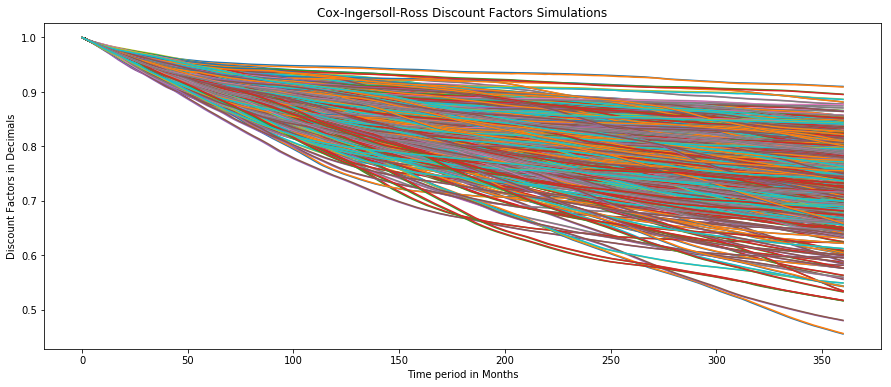

In [8]:
plt.figure(figsize=(15,6))
for i in Term_disc:
    plt.plot(i)
plt.ylabel("Discount Factors in Decimals")
plt.xlabel("Time period in Months")
plt.title("Cox-Ingersoll-Ross Discount Factors Simulations")

Text(0.5,1,'Cox-Ingersoll-Ross Short Rate Simulations')

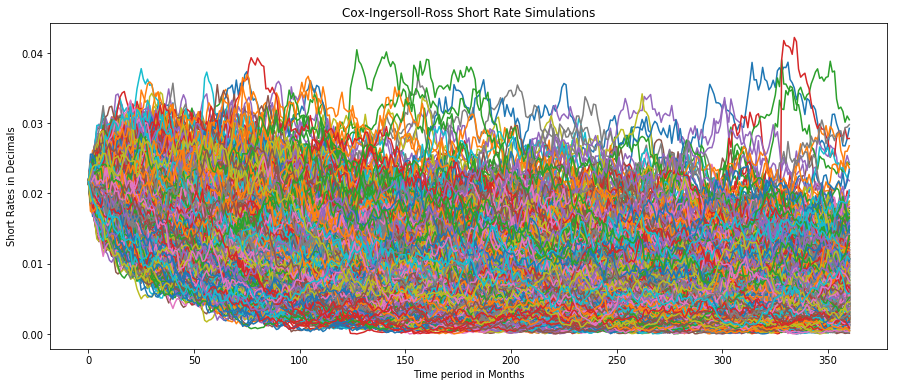

In [9]:
plt.figure(figsize=(15,6))
for i in Short_Rates:
    plt.plot(i)
plt.ylabel("Short Rates in Decimals")
plt.xlabel("Time period in Months")
plt.title("Cox-Ingersoll-Ross Short Rate Simulations")

In [13]:
def cashflows(We_Avg_co=0.07,MP=100000000,R=Short_Rates):
    #M= P[r(1+r)^n/((1+r)^n)-1)]
    r=We_Avg_co/12
    #Expected Payment
    Ex_CF=MP*(r*(1+r)**360)/((1+r)**360-1)
    #Seasoning Multilier
    Seasoning = np.ones(360);
    for i in range(0,28):
        Seasoning[i] = (i+1)/30;
    #Cyclical Seasonality
    Act_CF=[]
    Seasonality = [.94, .76 ,.73, .96, .98, .92, .99, 1.1, 1.18, 1.21, 1.23, .97]*30
    for j in R:
        CPR=[0]*360
        SMM=[0]*360
        Prin=[0]*360
        Intr=[0]*360
        Prin[0]=MP
        Pre_Princ=[0]*360
        Pool_Val=[0]*360
        Pool_Val[0]=MP
        Cash_Flow=[0]*360
        for i in range(1,360):
            if j[i+1]>0:
                refi=.2406-.1389*np.arctan(5.952*(1.089-We_Avg_co/j[i+1]))
            else:
                refi=.2406-.1389*np.arctan(-float("inf"))
            Intr[i]=Pool_Val[i-1]*We_Avg_co/12
            CPR[i]=refi*Seasoning[i]*Seasonality[i]*0.4
            SMM[i]=1-(1-CPR[i])**(1/12)
            # Amount of Principal paid
#             if Pool_Val[i-1]<Ex_CF:
#                 Prin[i]=Pool_Val[i-1]
#             else:
            Prin[i]=Ex_CF-Intr[i]
            Pre_Princ[i]=max(SMM[i]*(Pool_Val[i-1]-Prin[i]),0)
            if(Pool_Val[i-1]==0):
                Pool_Val[i]=0
            else:
                Pool_Val[i]=Pool_Val[i-1]-Prin[i]-Pre_Princ[i]

            Cash_Flow[i]=Prin[i]+Intr[i]+Pre_Princ[i]
            Ex_CF=Pool_Val[i]*(r*(1+r)**(360-i))/((1+r)**(360-i)-1)
        
        Act_CF.append(Cash_Flow)

    return(Act_CF)
    
    

Text(0.5,1,'Richard and Roll Prepayment Model Cash Flow Simulations')

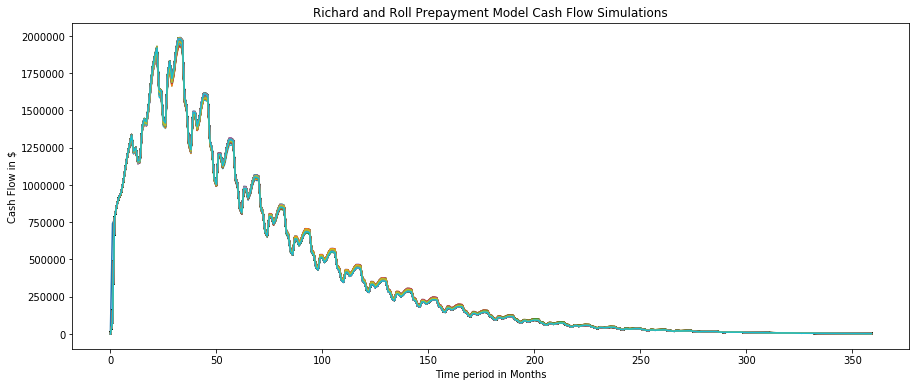

In [14]:
Act_CF=np.array(cashflows(We_Avg_co=0.07))
plt.figure(figsize=(15,6))
for i in Act_CF:
    plt.plot(i)
plt.ylabel("Cash Flow in $")
plt.xlabel("Time period in Months")
plt.title("Richard and Roll Prepayment Model Cash Flow Simulations")

In [15]:
Port_Value=[]
for i,j in zip(Term_disc,Act_CF):
    Port_Value.append(sum(np.array(i[1:]).T*np.array(j)))

128722761.34777631

71795.74553792225

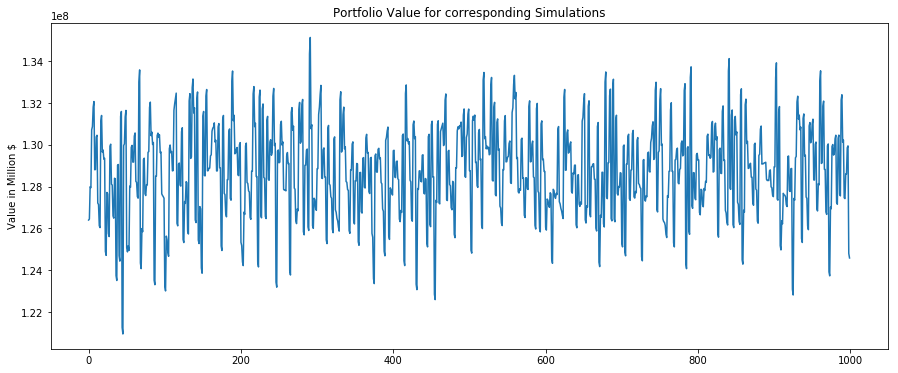

In [16]:
plt.figure(figsize=(15,6))
plt.plot(Port_Value)
plt.ylabel("Value in Million $")
plt.title("Portfolio Value for corresponding Simulations")
display(np.mean(Port_Value))
display(np.std(Port_Value)/np.sqrt(1000))

In [17]:
#Duration and Convexity using Finite Difference Methods
def ducon(R=Short_Rates,shift=0.001):
    SRS_p,disc_p=Short_shift(Spread=shift)
    SRS_n,disc_n=Short_shift(Spread=-shift)
    Act_n=cashflows(R=SRS_n)
    Act_p=cashflows(R=SRS_p)
    Port_Value_p=[]
    Port_Value_n=[]
    Port_Value=[]
    for i,j in zip(Term_disc,Act_CF):
        Port_Value.append(sum(np.array(i[1:]).T*np.array(j)))
    for i,j in zip(disc_p,Act_p):
        Port_Value_p.append(sum(np.array(i[1:]).T*np.array(j)))
    for i,j in zip(disc_n,Act_n):
        Port_Value_n.append(sum(np.array(i[1:]).T*np.array(j)))
    Value_p=np.mean(Port_Value_p)
    Value_n=np.mean(Port_Value_n)
    Value=np.mean(Port_Value)
    dur=(Value_n-Value_p)/(2*Value*shift)
    con=(Value_n+Value_p-2*Value)/(Value*(shift)**2)
    return(Value_p,Value,Value_n,dur,con)

In [18]:
ducon()

(128034667.26174547,
 128722761.34777631,
 129334106.00087155,
 5.0474318819782455,
 -596.2382420327201)